<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/ECSE552_T9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import pandas as pd
import json
import pickle
import math
from torch.optim import Adam
import torch.nn.functional as F
from tabulate import tabulate
from IPython.display import HTML, display

In [ ]:
!pip install pytorch_lightning
!pip install pytorch-ranger
from pytorch_ranger import RangerQH 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/articles_norm.csv.gz
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/news_dataset.py
!curl -O https://dl.sphericalcow.xyz/ecse552/T4/dict_logger.py
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/token2word.json
!curl -O https://dl.sphericalcow.xyz/ecse552/T7/word2token.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  10.9M      0  0:00:15  0:00:15 --:--:-- 11.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2488  100  2488    0     0  18992      0 --:--:-- --:--:-- --:--:-- 18992
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1635  100  1635    0     0  21800      0 --:--:-- --:--:-- --:--:-- 21513
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1482k  100 1482k    0     0  6075k      0 --:--:-- --:--:-- --:--:-- 6075k
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
with open('word2token.json') as f:
  word2token = json.load(f)

word2token['machine'], word2token['learning'], word2token['^'], word2token['$']

(5471, 4417, 0, 109)

In [ ]:
from dict_logger import DictLogger
from news_dataset import NewsDataset

In [ ]:

with open('token2word.json') as f:
  token2word = json.load(f)

token2word = {int(token): token2word[token] for token in token2word}
token2word[123], token2word[321]

('sunday', 'dorothee')

In [ ]:
def generate_batch(data_batch):

  content_batch, title_batch = [], []

  for (content, title) in data_batch:
    content_batch.append(torch.tensor(content))
    title_batch.append(torch.tensor(title))

  content_batch = pad_sequence(content_batch, padding_value=0, batch_first=False)
  title_batch = pad_sequence(title_batch, padding_value=0, batch_first=False)

  return content_batch, title_batch

In [ ]:
batch_size = 10

dataset = NewsDataset('articles_norm.csv.gz', token=True, column='content', target='title')
test_length = len(dataset)//10
train_length = len(dataset) - test_length
dataset_test, dataset_train = random_split(dataset, [test_length, train_length])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [ ]:
from random import randint
import matplotlib.pyplot as plt

embed_dim = 128
seq_len = 50

embedding = nn.Embedding(25600, embed_dim)
rand_in = torch.tensor([[randint(0, 25600) for _ in range(seq_len)], [randint(0, 25600) for _ in range(seq_len)]])
embed_out = embedding(rand_in)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

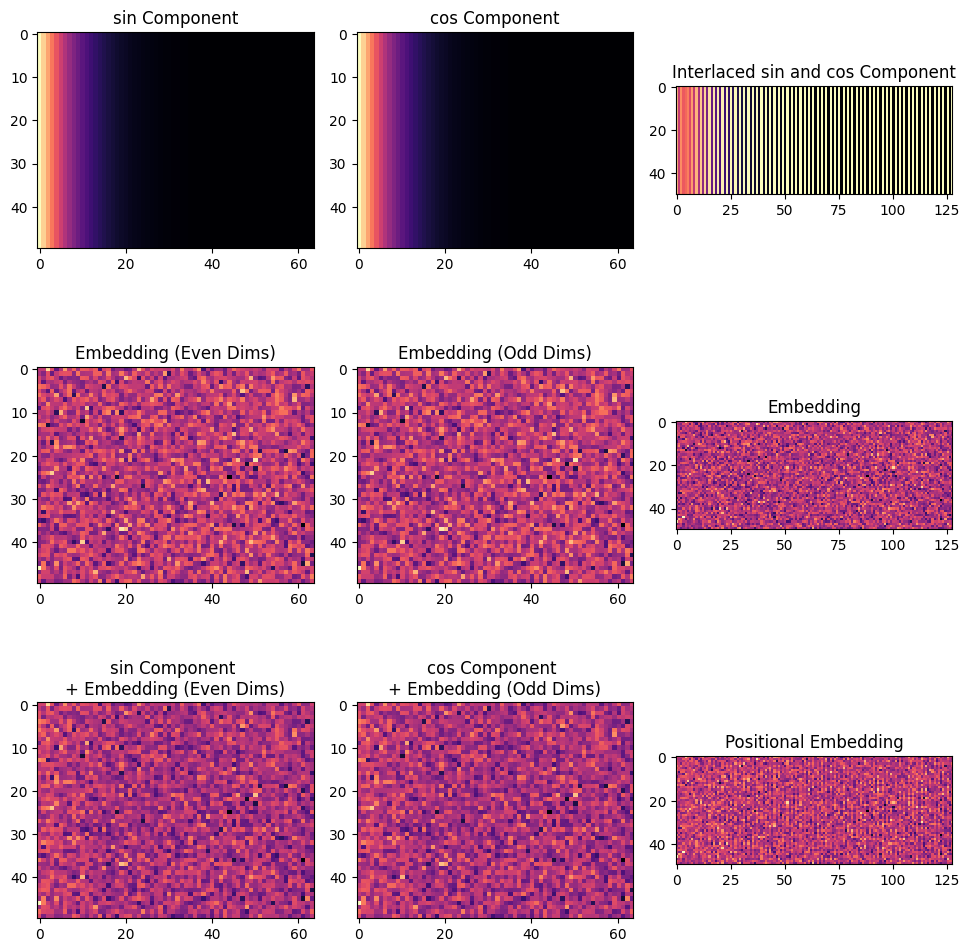

In [ ]:
pe = PositionalEncoding(embed_dim, 0, 5000)
pe_out = pe(embed_out)

fig, axs = plt.subplots(3, 3, figsize=(10,10), dpi=100)


axs[0, 0].set_title('sin Component')
axs[0, 0].imshow(pe_out[1, :, 0::2].detach().numpy() - embed_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[0, 1].set_title('cos Component')
axs[0, 1].imshow(pe_out[1, :, 0::2].detach().numpy() - embed_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[0, 2].set_title('Interlaced sin and cos Component')
axs[0, 2].imshow(pe_out[1].detach().numpy() - embed_out[1].detach().numpy(), cmap='magma', interpolation='nearest')

axs[1, 0].set_title('Embedding (Even Dims)')
axs[1, 0].imshow(embed_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[1, 1].set_title('Embedding (Odd Dims)')
axs[1, 1].imshow(embed_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[1, 2].set_title('Embedding')
axs[1, 2].imshow(embed_out[1].detach().numpy(), cmap='magma', interpolation='nearest')

axs[2, 0].set_title('sin Component \n+ Embedding (Even Dims)')
axs[2, 0].imshow(pe_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[2, 1].set_title('cos Component \n+ Embedding (Odd Dims)')
axs[2, 1].imshow(pe_out[1, :, 0::2].detach().numpy(), cmap='magma', interpolation='nearest')
axs[2, 2].set_title('Positional Embedding')
axs[2, 2].imshow(pe_out[1].detach().numpy(), cmap='magma', interpolation='nearest')


plt.tight_layout()
plt.show()

## Self-Attention

![self-attention figure](https://dl.sphericalcow.xyz/ecse552/T9/self_attention.png)

Figure by [Raimi Karim](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)